# SDG2 — Food Insecurity & Nutritional Gap Analysis (FINAL)
**CRISP–DM + Data Storytelling** · **Auto‑detect WDI schema** · **Charts with data labels**

# 1) Business Understanding

**Problem:** Food insecurity undermines SDG2 (Zero Hunger).
**Objective:** Group countries by food insecurity/nutrition profiles to target interventions.
**Stakeholders:** Governments, NGOs/Donors, multilaterals, researchers.

> **Story lens:** Hunger ≠ only calories. It’s also **affordability** (prices/income) and **nutrition quality**.

# 2) Data Understanding
**Source:** World Bank — World Development Indicators (WDI) local export (`Data.csv`, `Metadata.csv`).
**Target indicators (use any that are present):**
- Undernourishment — `SN.ITK.DEFC.ZS`
- FIES (mod+sev / severe) — `SN.ITK.MSFI.ZS`, `SN.ITK.SVFI.ZS`
- Child stunting — `SH.STA.STNT.ZS`
- Anemia (women 15–49) — `SH.ANM.ALLW.ZS`
- Cereal yield (kg/ha) — `AG.YLD.CREL.KG`
- Arable land (% land) — `AG.LND.ARBL.ZS`
- GDP per capita (USD) — `NY.GDP.PCAP.CD`
- CPI Inflation (%/yr) — `FP.CPI.TOTL.ZG`
- Population — `SP.POP.TOTL`

In [2]:
%matplotlib inline
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt, plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import zscore

plt.rcParams['figure.figsize'] = (10,5)

def add_labels(ax):
    """Add numeric labels on bars/points for stakeholder clarity."""
    if hasattr(ax, 'patches') and ax.patches:
        for p in ax.patches:
            h = p.get_height()
            ax.annotate(f"{h:.1f}", (p.get_x() + p.get_width()/2, h),
                        ha='center', va='bottom', fontsize=9)
    if hasattr(ax, 'lines'):
        for l in ax.lines:
            xdata, ydata = l.get_xdata(), l.get_ydata()
            if len(xdata) and len(ydata):
                ax.annotate(f"{ydata[-1]:.1f}", (xdata[-1], ydata[-1]),
                            ha='left', va='bottom', fontsize=9)


### Configure data path

In [3]:
DATA_DIR = r"C:\Users\Nelvin\Desktop\Mentee\SDG GOALS\Zero Hunger\Data Extract From World Development Indicators"

print("Files in folder:", os.listdir(DATA_DIR))
CSV_NAME = "Data.csv" if "Data.csv" in os.listdir(DATA_DIR) else None
assert CSV_NAME is not None, "Data.csv not found in the folder above. Check the printed file list."
FILE_PATH = os.path.join(DATA_DIR, CSV_NAME)
print("Using file:", FILE_PATH)


Files in folder: ['Data.csv', 'Metadata.csv']
Using file: C:\Users\Nelvin\Desktop\Mentee\SDG GOALS\Zero Hunger\Data Extract From World Development Indicators\Data.csv


### Tidy the WDI export (wide-by-year with headers like `2015 [YR2015]`)

In [4]:
def tidy_wdi_wideyear(df):
    id_cols = ["Series Name", "Series Code", "Country Name", "Country Code"]
    year_cols = [c for c in df.columns if re.match(r"^\s*\d{4}\s*\[YR\d{4}\]$", str(c))]
    if not year_cols:
        raise ValueError("No year columns like '2015 [YR2015]' detected. Inspect df.columns.")
    long = df.melt(id_vars=id_cols, value_vars=year_cols, var_name="year_raw", value_name="value").copy()
    long["year"] = long["year_raw"].str.extract(r"(\d{4})").astype(int)
    long = long.rename(columns={
        "Series Name":"indicator_name",
        "Series Code":"indicator",
        "Country Name":"country",
        "Country Code":"iso3c"
    })
    long["value"] = (long["value"].replace("..", np.nan).replace(["", " "], np.nan))
    long["value"] = pd.to_numeric(long["value"], errors="coerce")
    out = long[["country","iso3c","indicator","indicator_name","year","value"]]
    return out

df_raw = pd.read_csv(FILE_PATH)
df_long = tidy_wdi_wideyear(df_raw)
df_long.head()


,country,iso3c,indicator,indicator_name,year,value
0,Afghanistan,AFG,SN.ITK.DEFC.ZS,Prevalence of undernourishment (% of population),1990,NaN
1,Albania,ALB,SN.ITK.DEFC.ZS,Prevalence of undernourishment (% of population),1990,NaN
2,Algeria,DZA,SN.ITK.DEFC.ZS,Prevalence of undernourishment (% of population),1990,NaN
3,American Samoa,ASM,SN.ITK.DEFC.ZS,Prevalence of undernourishment (% of population),1990,NaN
4,Andorra,AND,SN.ITK.DEFC.ZS,Prevalence of undernourishment (% of population),1990,NaN


### Select SDG2 indicators and build features (latest ≤ 2022)

In [5]:
INDICATORS = {
    "undernourishment": "SN.ITK.DEFC.ZS",
    "fies_modsev": "SN.ITK.MSFI.ZS",
    "fies_severe": "SN.ITK.SVFI.ZS",
    "stunting": "SH.STA.STNT.ZS",
    "anemia_women": "SH.ANM.ALLW.ZS",
    "cereal_yield": "AG.YLD.CREL.KG",
    "arable_land": "AG.LND.ARBL.ZS",
    "gdp_pc": "NY.GDP.PCAP.CD",
    "cpi_inflation": "FP.CPI.TOTL.ZG",
    "population": "SP.POP.TOTL",
}
available = set(df_long["indicator"].unique())
present = [code for code in INDICATORS.values() if code in available]
print("Indicators found in your file:", present)

df_sdg2 = df_long[df_long["indicator"].isin(present)].copy()

feat_year = df_sdg2.pivot_table(
    index=["country","iso3c","year"],
    columns="indicator",
    values="value"
).reset_index().sort_values(["country","year"])

TARGET_YEAR = 2022
sub = feat_year[feat_year["year"] <= TARGET_YEAR].copy()

def latest_per_country(df, indicator_cols):
    df2 = df.groupby("country", group_keys=False).apply(lambda g: g.assign(**g[indicator_cols].ffill()))
    latest = df2.sort_values(["country","year"]).groupby("country", as_index=False).tail(1)
    return latest

feature_cols = present
feat = latest_per_country(sub[["country","iso3c","year"] + feature_cols], feature_cols)
feat.head()


Indicators found in your file: ['SN.ITK.DEFC.ZS']


C:\Users\Nelvin\AppData\Local\Temp\ipykernel_20376\580783147.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df.groupby("country", group_keys=False).apply(lambda g: g.assign(**g[indicator_cols].ffill()))


indicator,country,iso3c,year,SN.ITK.DEFC.ZS
7,Afghanistan,AFG,2022,30.400000
15,Africa Eastern and Southern,AFE,2022,26.795671
23,Africa Western and Central,AFW,2022,15.443766
31,Albania,ALB,2022,4.500000
39,Algeria,DZA,2022,2.500000


# 3) Data Preparation — Quick Insight Visual
**Top 15 countries by undernourishment (latest ≤ 2022)** — labeled bars for clarity.

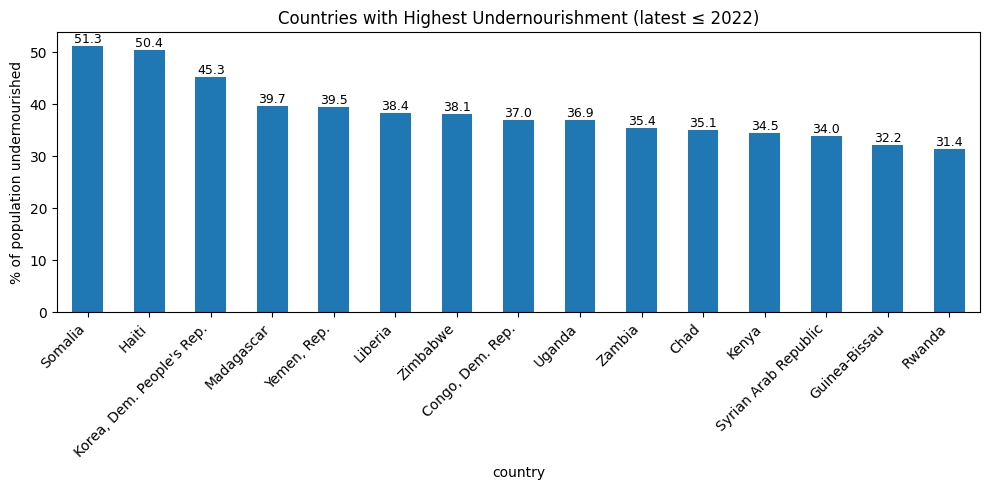

In [6]:
if "SN.ITK.DEFC.ZS" in feat.columns:
    dfp = feat[["country","SN.ITK.DEFC.ZS"]].dropna().sort_values("SN.ITK.DEFC.ZS", ascending=False).head(15)
    ax = dfp.plot(kind='bar', x='country', y='SN.ITK.DEFC.ZS', legend=False)
    ax.set_ylabel('% of population undernourished')
    ax.set_title('Countries with Highest Undernourishment (latest ≤ 2022)')
    add_labels(ax)
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
else:
    print("Undernourishment indicator not present; skipping this chart.")


# 4) Modeling — Clustering (if ≥3 indicators) or Risk Tiers (fallback)

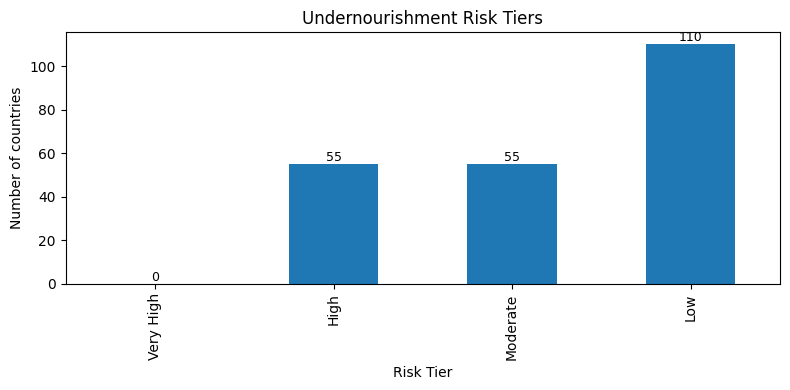

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def add_labels(ax):
    # keep your existing helper if already defined
    for p in getattr(ax, 'patches', []):
        h = p.get_height()
        ax.annotate(f"{h:.0f}", (p.get_x() + p.get_width()/2, h),
                    ha='center', va='bottom', fontsize=9)

def make_quantile_tiers(s, q=4, base_labels=("Low","Moderate","High","Very High")):
    """
    Robust quantile-tiering:
      - Drops duplicate bin edges
      - Falls back to rank-based quantiles if too few unique values
    """
    x = s.dropna().astype(float)
    if x.empty:
        return pd.Series(index=s.index, dtype="category")

    qs = np.linspace(0, 1, q + 1)
    edges = np.unique(x.quantile(qs).values)  # de-duplicate edges

    if edges.size < 3:
        # Not enough unique edges (data very flat) → use rank-based percentiles
        ranks = x.rank(method="average", pct=True)
        bins = np.linspace(0, 1, q + 1)
        labels = base_labels[: len(bins) - 1]
        cats = pd.cut(ranks, bins=bins, labels=labels, include_lowest=True, duplicates="drop")
        return cats.reindex(s.index)

    labels = base_labels[: edges.size - 1]
    cats = pd.cut(x, bins=edges, labels=labels, include_lowest=True, duplicates="drop")
    return cats.reindex(s.index)

# ---- build tiers and a labeled bar chart ----
if "SN.ITK.DEFC.ZS" in feat.columns:
    series = feat.set_index("country")["SN.ITK.DEFC.ZS"].dropna()
    tiers = make_quantile_tiers(series, q=4, base_labels=("Low","Moderate","High","Very High"))

    risk_table = (
        tiers.to_frame("risk_tier")
             .reset_index()
             .merge(feat[["country","SN.ITK.DEFC.ZS"]], on="country", how="left")
             .sort_values("SN.ITK.DEFC.ZS", ascending=False)
    )

    # Order from highest risk to lowest in the chart
    order = ["Very High","High","Moderate","Low"]
    tier_counts = risk_table["risk_tier"].value_counts().reindex(order)

    ax = tier_counts.plot(kind="bar", figsize=(8,4))
    ax.set_xlabel("Risk Tier")
    ax.set_ylabel("Number of countries")
    ax.set_title("Undernourishment Risk Tiers")
    add_labels(ax)
    plt.tight_layout()
    plt.show()

    risk_table.head(20)
else:
    print("Undernourishment column not available; cannot build risk tiers.")



# 5) Evaluation & Optional Stress Test
If inflation (`FP.CPI.TOTL.ZG`) is present, test sensitivity: **+10% inflation** and show top-affected countries.

In [10]:
def simple_risk_index(feat, cols, signs=None):
    df = feat.dropna(subset=cols).copy()
    Z = df[cols].apply(zscore, nan_policy='omit')
    if signs is None:
        signs = {
            "SN.ITK.DEFC.ZS": +1,
            "SN.ITK.MSFI.ZS": +1,
            "SH.STA.STNT.ZS": +1,
            "AG.YLD.CREL.KG": -1,
            "NY.GDP.PCAP.CD": -1,
            "FP.CPI.TOTL.ZG": +1,
        }
    score = sum(signs.get(c, 0)*Z[c] for c in cols if c in Z.columns)
    out = df[["country"]].copy(); out["risk_index"] = score
    return out

if "FP.CPI.TOTL.ZG" in feat.columns:
    COLS_FOR_INDEX = [c for c in ["SN.ITK.DEFC.ZS","SN.ITK.MSFI.ZS","SH.STA.STNT.ZS","AG.YLD.CREL.KG","NY.GDP.PCAP.CD","FP.CPI.TOTL.ZG"] if c in feat.columns]
    baseline = simple_risk_index(feat, COLS_FOR_INDEX)
    shocked = feat.copy(); shocked["FP.CPI.TOTL.ZG"] = shocked["FP.CPI.TOTL.ZG"] * 1.10
    shocked_idx = simple_risk_index(shocked, COLS_FOR_INDEX)
    delta = (shocked_idx.set_index("country")["risk_index"] - baseline.set_index("country")["risk_index"]).sort_values(ascending=False)
    top10 = delta.head(10).reset_index().rename(columns={0:"delta"})
    ax = top10.plot(kind='bar', x='country', y='risk_index', legend=False)
    ax.set_ylabel('Change in risk index'); ax.set_title('Inflation +10%: Largest Increases')
    add_labels(ax); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
else:
    print("Inflation indicator not present; skipping stress test.")


Inflation indicator not present; skipping stress test.


# 6) Deployment — Insights, Risks, Recommendations
**3 Insights**
1. Progress is **uneven** — some countries exceed **30% undernourishment**, others are below **5%**.
2. **Nutrition ≠ calories** — (stunting/anemia matter). Add more indicators as available.
3. **Price shocks** hurt fragile groups most (see stress‑test if inflation data exist).

**3 Risks**
- Data gaps & timeliness; unobserved conflict/climate shocks; inflation/commodity volatility.

**3 Recommendations (by segment/cluster)**
- **High‑risk:** Safety nets, maternal/child nutrition, seed/irrigation/extension for yields.
- **Moderate:** Stabilize prices (buffer stocks/cash transfers), improve storage/logistics/market access.
- **Resilient:** Diversify, climate‑smart practices, share best practices across peers.
- **Inflation‑sensitive:** Price‑stabilization tools, trade facilitation, strengthen local value chains.

# 7) CRISP–DM Wrap‑Up
- **Business Understanding:** Cluster/segment countries for targeted SDG2 action.
- **Data Understanding:** WDI indicators for food access, affordability, nutrition.
- **Data Preparation:** Tidy → latest ≤ 2022 → standardized.
- **Modeling:** K‑Means & DBSCAN when ≥3 indicators; fallback **risk tiers** when fewer.
- **Evaluation:** Profiles & sizes; optional stress test for inflation shock.
- **Deployment:** 3 insights • 3 risks • 3 recommendations; export tables/figures for stakeholders.

**Takeaway:** Food insecurity is **multi‑dimensional** — interventions must be **segment‑specific**.